In [5]:
%pip install nltk


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 3.1 MB/s eta 0:00:00
Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 785.1/785.1 kB 23.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from time import time
import numpy as np
import matplotlib.pyplot as plt; plt.style.use('dark_background')
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import warnings; warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectPercentile, f_classif, RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
col_names = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot'
            ,'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations'
            ,'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate'
            ,'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count'
            ,'dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate'
            ,'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate'
            ,'outcome','level']

num_features = ['duration','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot'
            ,'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations'
            ,'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate'
            ,'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count'
            ,'dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate'
            ,'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate'
            ,'level']

kdd_train = pd.read_csv("../NSL_KDD/KDDTrain+.txt", names = col_names)
kdd_test = pd.read_csv("../NSL_KDD/KDDTest+.txt", names = col_names)
kdd_train.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,level
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,...,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,...,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240,19.504060
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,...,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459,2.291503
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,21.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,...,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000


In [3]:
len(num_features)

39

# Binary Classification

In [12]:
nsl_kdd_train = kdd_train.copy()
nsl_kdd_test = kdd_test.copy()

nsl_kdd_train.loc[nsl_kdd_train['outcome'] == "normal", "outcome"] = 'normal'
nsl_kdd_train.loc[nsl_kdd_train['outcome'] != 'normal', "outcome"] = 'attack'
print(nsl_kdd_train["outcome"].value_counts())

nsl_kdd_test.loc[nsl_kdd_test['outcome'] == "normal", "outcome"] = 'normal'
nsl_kdd_test.loc[nsl_kdd_test['outcome'] != 'normal', "outcome"] = 'attack'
print(nsl_kdd_test["outcome"].value_counts())

outcome
normal    67343
attack    58630
Name: count, dtype: int64
outcome
attack    12833
normal     9711
Name: count, dtype: int64


In [13]:
X_train = nsl_kdd_train[num_features]
X_test = nsl_kdd_test[num_features]
y_train = nsl_kdd_train["outcome"]
y_test = nsl_kdd_test["outcome"]

X = pd.concat([X_train, X_test])

# Concatenate labels
y = pd.concat([y_train, y_test])

# Reset index to ensure continuous indexing
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

In [14]:
# Assuming 'features' is your DataFrame
scaler = MinMaxScaler()

# Apply Min-Max scaling to each column separately
X_train_scaled = X_train.copy()
for column in X_train.columns:
    column_data = X_train[column].values.reshape(-1, 1)
    X_train_scaled[column] = scaler.fit_transform(column_data)

# If you want to keep the scaled data in the original DataFrame
X_train_scaled.columns = X_train.columns

# Apply Min-Max scaling to each column separately
X_test_scaled = X_test.copy()
for column in X_test.columns:
    column_data = X_test[column].values.reshape(-1, 1)
    X_test_scaled[column] = scaler.fit_transform(column_data)

# If you want to keep the scaled data in the original DataFrame
X_test_scaled.columns = X_test.columns

# Apply Min-Max scaling to each column separately
X_scaled = X.copy()
for column in X.columns:
    column_data = X[column].values.reshape(-1, 1)
    X_scaled[column] = scaler.fit_transform(column_data)

# If you want to keep the scaled data in the original DataFrame
X_scaled.columns = X.columns

In [11]:
#Training a classifier
clf = RandomForestClassifier(n_estimators=20, max_depth=20, random_state = 0)
# clf = RandomForestClassifier( random_state = 0)
t0 = time()
clf.fit(X_train_scaled, y_train)
tt = time() - t0
print ("Classifier trained in {} seconds.".format(round(tt, 3)))

Classifier trained in 0.992 seconds.


In [7]:
# Prediction on train set
t0 = time()
pred_train = clf.predict(X_train_scaled)
tt = time() - t0
print ("Classifier predicted on train set in {} seconds.".format(round(tt, 3)))

# Prediction on test set
t0 = time()
pred_test = clf.predict(X_test_scaled)
tt = time() - t0
print ("Classifier predicted on test set in {} seconds.".format(round(tt, 3)))

# Metrics
precision = precision_score(y_test, pred_test, average='micro')
recall = recall_score(y_test, pred_test, average='micro')
f1 = f1_score(y_test, pred_test, average='micro')
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, pred_test)

# Printing results
print("Accuracy train: ", accuracy_train)
print("Accuracy test: ", accuracy_test)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

Classifier predicted on train set in 0.221 seconds.
Classifier predicted on test set in 0.04 seconds.
Accuracy train:  0.9999126797012058
Accuracy test:  0.8107700496806246
Precision:  0.8107700496806246
Recall:  0.8107700496806246
F1 Score:  0.8107700496806246


# Non-binary classification

In [3]:
nsl_kdd_train = kdd_train.copy()
nsl_kdd_test = kdd_test.copy()

X_train = nsl_kdd_train[num_features]
X_test = nsl_kdd_test[num_features]
y_train = nsl_kdd_train["outcome"]
y_test = nsl_kdd_test["outcome"]
y_train.value_counts()

outcome
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: count, dtype: int64

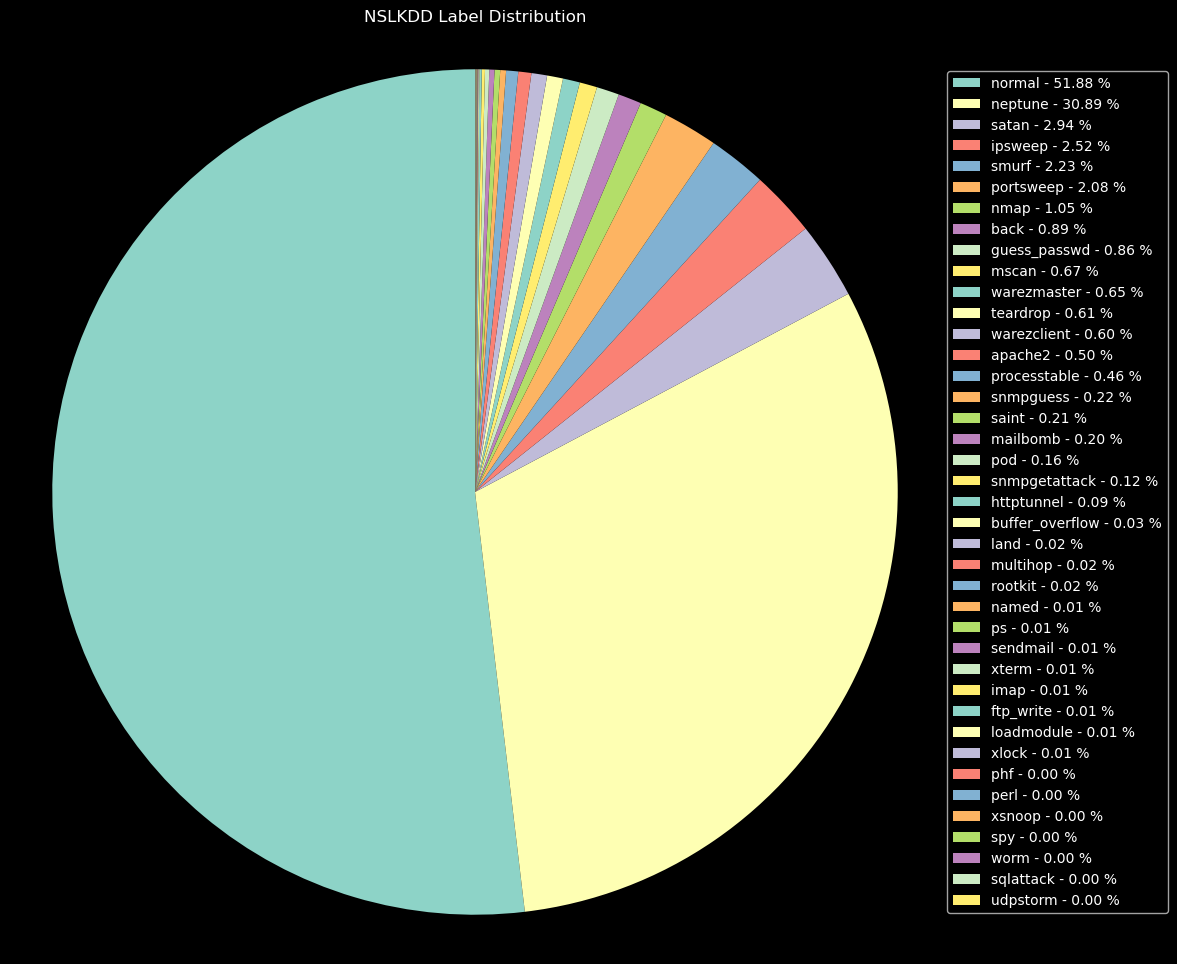

In [7]:
# Concatenate y_train and y_test vertically
y_combined = pd.concat([y_train, y_test])

# Optionally, reset the index of the combined DataFrame
y_combined.reset_index(drop=True, inplace=True)
label_series = pd.Series(y_combined.value_counts())

# Get labels and counts from the dictionary
labels = label_series.index
counts = label_series.values
percent = 100.*counts/counts.sum()

# Create a pie chart
plt.figure(figsize=(12, 12))
wedges, _ = plt.pie(counts, startangle=90, radius=1.2)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, percent)]
plt.title('NSLKDD Label Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.legend(wedges, labels, loc="center left", bbox_to_anchor=(1, 0.5))
plt.savefig('NSLKDD_label_dist.png', bbox_inches='tight')
plt.show()

In [5]:
# Assuming 'features' is your DataFrame
scaler = MinMaxScaler()

# Apply Min-Max scaling to each column separately
X_train_scaled = X_train.copy()
for column in X_train.columns:
    column_data = X_train[column].values.reshape(-1, 1)
    X_train_scaled[column] = scaler.fit_transform(column_data)

# If you want to keep the scaled data in the original DataFrame
X_train_scaled.columns = X_train.columns

# Apply Min-Max scaling to each column separately
X_test_scaled = X_test.copy()
for column in X_test.columns:
    column_data = X_test[column].values.reshape(-1, 1)
    X_test_scaled[column] = scaler.fit_transform(column_data)

# If you want to keep the scaled data in the original DataFrame
X_test_scaled.columns = X_test.columns

In [10]:
#Training a classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state = 0)
# clf = RandomForestClassifier( random_state = 0)
t0 = time()
clf.fit(X_train_scaled, y_train)
tt = time() - t0
print ("Classifier trained in {} seconds.".format(round(tt, 3)))

Classifier trained in 11.31 seconds.


In [11]:
# Prediction on train set
t0 = time()
pred_train = clf.predict(X_train_scaled)
tt = time() - t0
print ("Classifier predicted on train set in {} seconds.".format(round(tt, 3)))

# Prediction on test set
t0 = time()
pred_test = clf.predict(X_test_scaled)
tt = time() - t0
print ("Classifier predicted on test set in {} seconds.".format(round(tt, 3)))

# Metrics
precision = precision_score(y_test, pred_test, average='micro')
recall = recall_score(y_test, pred_test, average='micro')
f1 = f1_score(y_test, pred_test, average='micro')
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, pred_test)

# Printing results
print("Accuracy train: ", accuracy_train)
print("Accuracy test: ", accuracy_test)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

Classifier predicted on train set in 2.221 seconds.
Classifier predicted on test set in 0.344 seconds.
Accuracy train:  0.9998650504473181
Accuracy test:  0.6980571327182399
Precision:  0.6980571327182399
Recall:  0.6980571327182399
F1 Score:  0.6980571327182399


# PCA

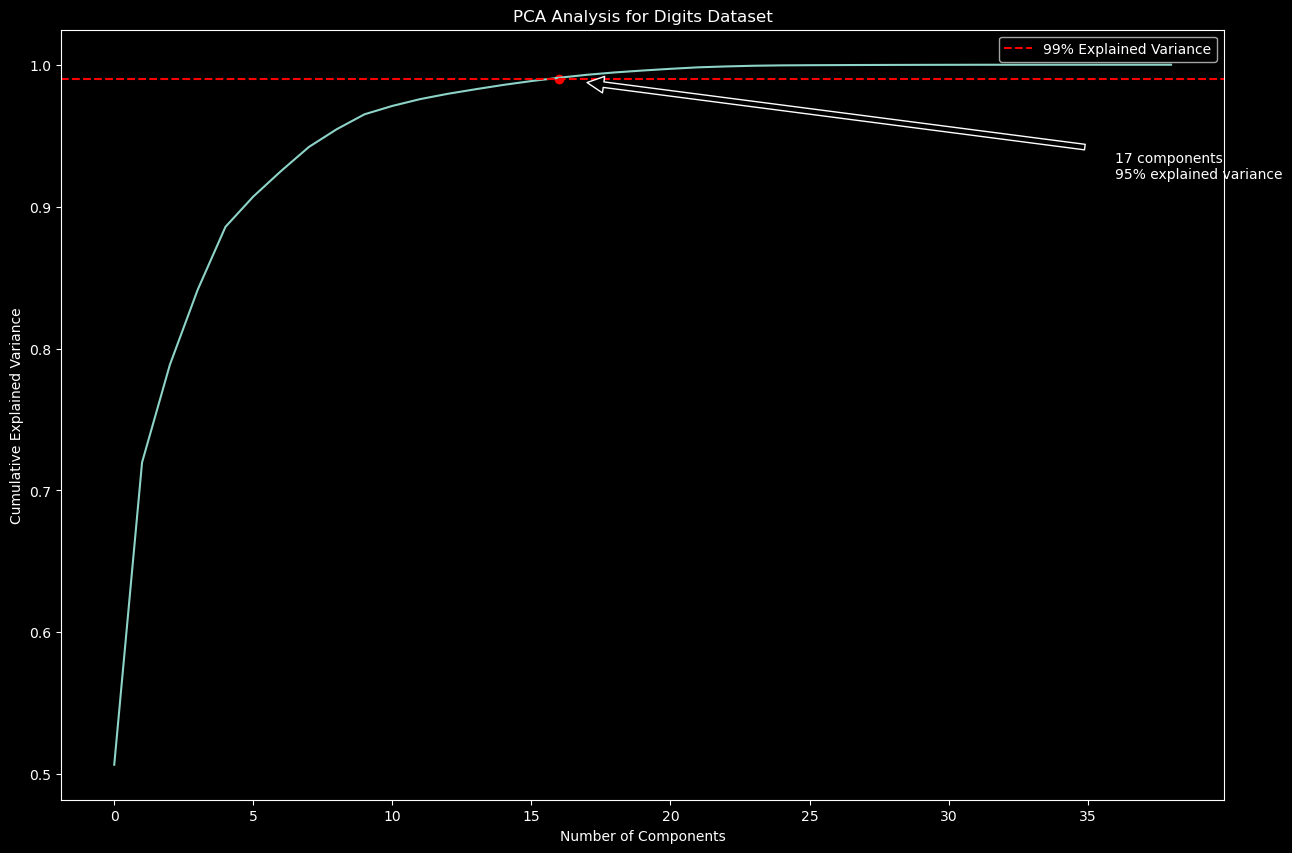

In [45]:
pca = PCA().fit(X_train_scaled)

fig, ax = plt.subplots( figsize=(15, 10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Analysis for Digits Dataset')
plt.axhline(y=0.99, color='r', linestyle='--', label='99% Explained Variance')
plt.legend()

# Find the index where cumulative explained variance first exceeds 95%
index_95_percent = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.99)

# Add a marker at the 95% point
plt.scatter(index_95_percent, 0.99, color='r', marker='o')

# Annotate the point with text
plt.annotate(f'{index_95_percent+1} components\n95% explained variance',
             xy=(index_95_percent, 0.99), xytext=(index_95_percent+20, 0.92),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

In [13]:
pca = PCA(n_components=index_95_percent)
pca_train = pca.fit_transform(X_train_scaled)
pca_test = pca.transform(X_test_scaled)
print(index_95_percent)

8


In [14]:
#Predictions on the test data
clf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state = 0)
t0 = time()
clf.fit(pca_train, y_train)
tt = time() - t0
print ("Trained in {} seconds".format(round(tt,3)))

Trained in 30.646 seconds


In [15]:
# Prediction on train set
t0 = time()
pred_train = clf.predict(pca_train)
tt = time() - t0
print ("Classifier predicted on train set in {} seconds.".format(round(tt, 3)))

# Prediction on test set
t0 = time()
pred_test = clf.predict(pca_test)
tt = time() - t0
print ("Classifier predicted on test set in {} seconds.".format(round(tt, 3)))

# Metrics
precision = precision_score(y_test, pred_test, average='micro')
recall = recall_score(y_test, pred_test, average='micro')
f1 = f1_score(y_test, pred_test, average='micro')
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, pred_test)

# Printing results
print("Accuracy train: ", accuracy_train)
print("Accuracy test: ", accuracy_test)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("Optimal number of components: ", index_95_percent)

Classifier predicted on train set in 1.904 seconds.
Classifier predicted on test set in 0.341 seconds.
Accuracy train:  0.9997062862676923
Accuracy test:  0.6851046841731725
Precision:  0.6851046841731725
Recall:  0.6851046841731725
F1 Score:  0.6851046841731725


# Selecting the best features

In [12]:
# Create a LabelEncoder instance
label_encoder = LabelEncoder()

y_train_encoded = y_train.copy()
y_test_encoded = y_test.copy()

# Fit the encoder on the labels and transform the column
y_train_encoded = label_encoder.fit_transform(y_train_encoded)
y_test_encoded = label_encoder.fit_transform(y_test_encoded)

y_train_encoded = pd.DataFrame(y_train_encoded)
y_test_encoded = pd.DataFrame(y_test_encoded)

combined_X = pd.concat([X_train_scaled, X_test_scaled], ignore_index=True)
combined_y = pd.concat([y_train_encoded, y_test_encoded], ignore_index=True)

In [38]:
# Define a list of percentiles to test
percentiles = [10, 15, 20, 25, 30]

# Create a pipeline with feature selection and your classifier
model = make_pipeline(SelectPercentile(score_func=f_classif), RandomForestClassifier())

# Store accuracies for each percentile
accuracies = []

# Perform cross-validation for each percentile
for percentile in tqdm(percentiles):
    model.set_params(selectpercentile__percentile=percentile)
    scores = cross_val_score(model, combined_X, combined_y, cv=5)
    accuracies.append(scores.mean())

# Print accuracies for each percentile
for percentile, accuracy in zip(percentiles, accuracies):
    print(f"Percentile: {percentile}, Mean Accuracy: {accuracy}")



# Initialize variables to store the optimal percentile and accuracy
optimal_percentile = None
optimal_accuracy = None

# Iterate through the percentiles and accuracies
for i in range(len(percentiles) - 1):
    gap_accuracy = accuracies[i+1] - accuracies[i]
    if gap_accuracy < 0.005:
        optimal_percentile = percentiles[i]
        optimal_accuracy = accuracies[i]
        break

# If no percentile meets the condition, choose the last one
if optimal_percentile is None:
    optimal_percentile = percentiles[-1]
    optimal_accuracy = accuracies[-1]

print(f"Optimal Percentile: {optimal_percentile}, Optimal Accuracy: {optimal_accuracy}")


100%|██████████| 5/5 [02:44<00:00, 32.89s/it]

Percentile: 10, Mean Accuracy: 0.7602025711242983
Percentile: 15, Mean Accuracy: 0.7663096416803035
Percentile: 20, Mean Accuracy: 0.7787324531263313
Percentile: 25, Mean Accuracy: 0.808109515054593
Percentile: 30, Mean Accuracy: 0.8392373046894391
Optimal Percentile: 10, Optimal Accuracy: 0.7602025711242983


In [44]:
selector = SelectPercentile(score_func=f_classif, percentile=30)

# Fit and transform the training set
X_train_selected = selector.fit_transform(X_train_scaled, y_train_encoded)

# Use the selected features to transform the test set
X_test_selected = selector.transform(X_test_scaled)

In [45]:
#Predictions on the test data
clf = RandomForestClassifier(random_state = 0)
t0 = time()
clf.fit(X_train_selected, y_train_encoded)
tt = time() - t0
print ("Trained in {} seconds".format(round(tt,3)))

Trained in 7.151 seconds


In [46]:
# Prediction on train set
t0 = time()
pred_train = clf.predict(X_train_selected)
tt = time() - t0
print ("Classifier predicted on train set in {} seconds.".format(round(tt, 3)))

# Prediction on test set
t0 = time()
pred_test = clf.predict(X_test_selected)
tt = time() - t0
print ("Classifier predicted on test set in {} seconds.".format(round(tt, 3)))

# Metrics
precision = precision_score(y_test_encoded, pred_test, average='micro')
recall = recall_score(y_test_encoded, pred_test, average='micro')
f1 = f1_score(y_test_encoded, pred_test, average='micro')
accuracy_train = accuracy_score(y_train_encoded, pred_train)
accuracy_test = accuracy_score(y_test_encoded, pred_test)

# Printing results
print("Accuracy train: ", accuracy_train)
print("Accuracy test: ", accuracy_test)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("% feature selected", optimal_percentile)

Classifier predicted on train set in 2.222 seconds.
Classifier predicted on test set in 0.395 seconds.
Accuracy train:  0.976320322608813
Accuracy test:  0.03681689141234919
Precision:  0.03681689141234919
Recall:  0.03681689141234919
F1 Score:  0.03681689141234919
% feature selected 10


# Best n features

In [21]:
min_features_to_select = 10 
clf = RandomForestClassifier()
cv = StratifiedKFold(5)

rfecv = RFECV(
    estimator=clf,
    step=5,
    cv=cv,
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
rfecv.fit(X_train_scaled, y_train)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 39


In [23]:
selected_feature_indices = rfecv.support_
selected_feature_names = [num_features[i] for i, selected in enumerate(selected_feature_indices) if selected]

print("Selected Features:", selected_feature_names)

reduced_X_train = X_train[selected_feature_names]
reduced_X_test = X_test[selected_feature_names]

Selected Features: ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'level']


In [24]:
# Fit and transform the training set

In [25]:
#Predictions on the test data
clf = RandomForestClassifier(random_state = 0)
t0 = time()
clf.fit(reduced_X_train, y_train)
tt = time() - t0
print ("Trained in {} seconds".format(round(tt,3)))

Trained in 9.46 seconds


In [27]:
# Prediction on train set
t0 = time()
pred_train = clf.predict(reduced_X_train)
tt = time() - t0
print ("Classifier predicted on train set in {} seconds.".format(round(tt, 3)))

# Prediction on test set
t0 = time()
pred_test = clf.predict(reduced_X_test)
tt = time() - t0
print ("Classifier predicted on test set in {} seconds.".format(round(tt, 3)))

# Metrics
precision = precision_score(y_test, pred_test, average='micro')
recall = recall_score(y_test, pred_test, average='micro')
f1 = f1_score(y_test, pred_test, average='micro')
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, pred_test)

# Printing results
print("Accuracy train: ", accuracy_train)
print("Accuracy test: ", accuracy_test)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("N features selected", len(reduced_X_test.columns))

Classifier predicted on train set in 1.985 seconds.
Classifier predicted on test set in 0.297 seconds.
Accuracy train:  0.9999285561191684
Accuracy test:  0.723207948899929
Precision:  0.723207948899929
Recall:  0.723207948899929
F1 Score:  0.7232079488999289
N features selected 39


In [ ]:
import psutil
# Measure memory usage before training the model
memory_before = psutil.virtual_memory().used

#Predictions on the test data
clf = RandomForestClassifier(random_state = 0)
t0 = time()
clf.fit(X_train, y_train)
tt = time() - t0
print ("Trained in {} seconds".format(round(tt,3)))

# Measure memory usage after training the model
memory_after = psutil.virtual_memory().used

# Calculate the memory usage during the training process
memory_used = memory_after - memory_before

print(f"Memory used during training: {memory_used / 1024 / 1024:.2f} MB")

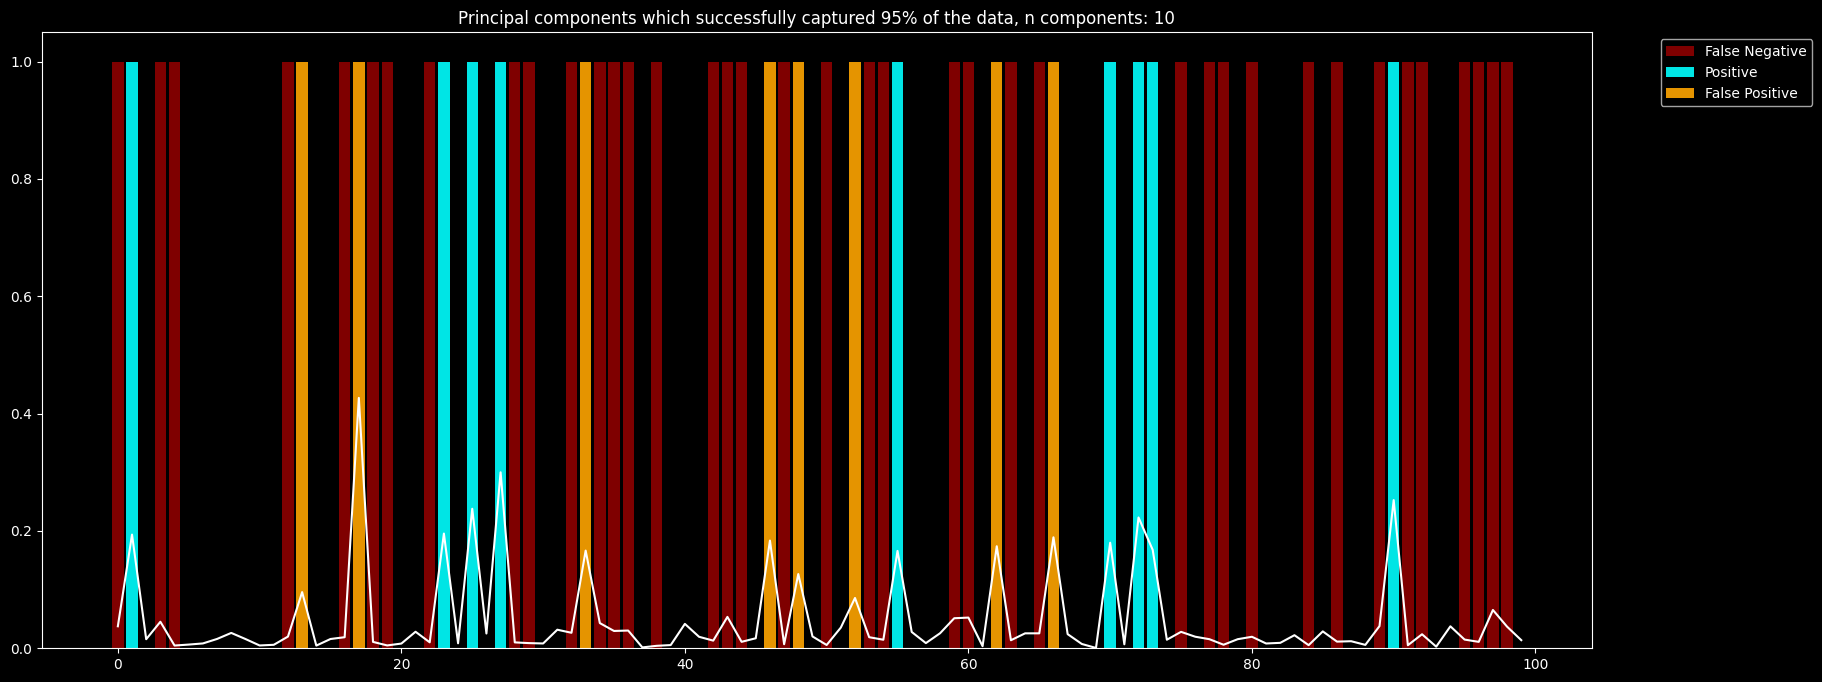

In [36]:
from collections import OrderedDict

THRESHOLD = 100
label_encoder = LabelEncoder()

y_encoded = y.copy()

# Fit the encoder on the labels and transform the column
y_encoded = label_encoder.fit_transform(y_encoded)
y_encoded = y_encoded[:THRESHOLD]

def get_anomaly_scores(df_original, df_restored):
    loss = np.sum((np.array(df_original) - np.array(df_restored)) ** 2, axis=1)
    loss = pd.Series(data=loss, index=df_original.index)
    return loss

#  loss = np.sum((np.array(df_original) - np.array(df_restored)) ** 2, axis=1)
#loss = pd.Series(data=loss, index=df_original.index)
    #return loss
pca = PCA(n_components=10, random_state=0)
pca_df = pd.DataFrame(pca.fit_transform(X_scaled.head(THRESHOLD)))
df_restored = pd.DataFrame(pca.inverse_transform(pca_df), index=pca_df.index)

scores = get_anomaly_scores(X_scaled.head(THRESHOLD), df_restored)

dummy_plots = []

plt.figure(figsize=(20, 8))
plt.plot(scores, color="white")
for i, (score, y_val) in enumerate(zip(scores, y_encoded)):
    if score > 0.08 and y_val == 1:
        plt.bar(i, 1, color='cyan', alpha=0.9, label="Positive")
    elif score > 0.08:
        plt.bar(i, 1, color='orange', alpha=0.9, label="False Positive")
    elif y_val == 1:
        plt.bar(i, 1, color='red', alpha=0.5, label="False Negative")
# Plot title
plt.title("Principal components which successfully captured 95% of the data, n components: {}".format(10))
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.04, 1), loc="upper left")
# Add legend with custom labels
plt.savefig('../images/NSLKDD_pca_vs_read.png')
plt.show()

In [33]:
y_encoded

array([1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1])

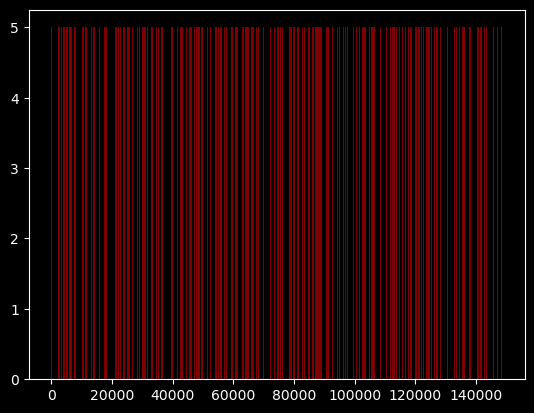

In [216]:
# Plot bars only where y_encoded is 5
for i, val in enumerate(y_encoded):
    if val == 5:
        plt.bar(i, val, color='red', alpha=0.5)

plt.show()

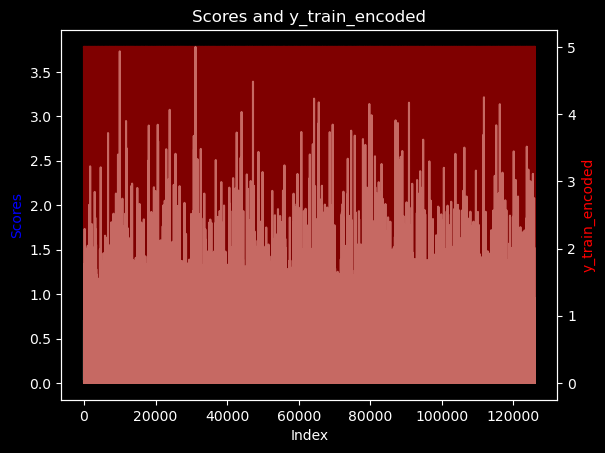

In [27]:
fig, ax1 = plt.subplots()

# Plot 'scores' on the first y-axis
ax1.plot(scores, label='Scores')
ax1.set_xlabel('Index')
ax1.set_ylabel('Scores', color='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.plot(y_train_encoded, alpha=0.5, color='red', label='y_train_encoded')
ax2.set_ylabel('y_train_encoded', color='red')

plt.title('Scores and y_train_encoded')
plt.show()